In [1]:
def mpNumCoEvents(closeIdx, t1, molecule):
    """
    Compute number of concurrent events per bar.

    Parameters:
    - closeIdx: pd.Index of close prices (usually datetime index)
    - t1: pd.Series where index is event start time and value is event end time
    - molecule: list-like with timestamps (subset of t1.index) to compute on

    Returns:
    - count: pd.Series with index as closeIdx and values as number of overlapping events
    """

    # 1) Ensure all t1 values are filled (use last close if NaN)
    t1 = t1.fillna(closeIdx[-1])

    # 2) Keep only events that start after or at the first molecule time
    t1 = t1[t1 >= molecule[0]]

    # 3) And end before or at the last end time in this molecule
    t1 = t1.loc[:t1[molecule].max()]

    # 4) Find the time window we're working in
    iloc_start, iloc_end = closeIdx.searchsorted([t1.index[0], t1.max()])
    barIdx = closeIdx[iloc_start: iloc_end + 1]

    # 5) Initialize count Series
    count = pd.Series(0, index=barIdx)

    # 6) Count how many events overlap each time point
    for t_in, t_out in t1.items():
        count.loc[t_in:t_out] += 1

    return count.loc[molecule[0]: t1[molecule].max()]


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from multiprocessing.dummy import Pool as ThreadPool  # or use multiprocessing.Pool for CPU-bound
import datetime as dt
import sys
import time


from Multiprocessing import mpPandasObj

df = yf.download('AAPL', start='2025-06-01', end='2025-07-07', interval='5m')
df = df[['Close']].dropna()
df.columns = ['Close']  # Flatten multi-index if needed
df.index = pd.to_datetime(df.index)
close = df['Close']  # This must be a Series



def getEvents(close, threshold=0.01, horizon=3):
    """
    Generate events: when return over next `horizon` bars exceeds threshold.
    """
    events = []
    for i in range(len(close) - horizon):
        t0 = close.index[i]
        t1 = close.index[i + horizon]
        ret = (close.iloc[i + horizon] / close.iloc[i]) - 1
        if abs(ret) > threshold:
            events.append((t0, t1))

    # Move this outside the loop!
    events_df = pd.DataFrame(events, columns=['t0', 't1']).set_index('t0')
    return events_df

events = getEvents(close, threshold=0.0025, horizon=3)

print(events.head())
print(f"Generated {len(events)} events.")


/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_4802/567294291.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2025-06-01', end='2025-07-07', interval='5m')
[*********************100%***********************]  1 of 1 completed

                                                 t1
t0                                                 
2025-06-02 13:30:00+00:00 2025-06-02 13:45:00+00:00
2025-06-02 13:45:00+00:00 2025-06-02 14:00:00+00:00
2025-06-02 13:50:00+00:00 2025-06-02 14:05:00+00:00
2025-06-02 14:15:00+00:00 2025-06-02 14:30:00+00:00
2025-06-02 14:45:00+00:00 2025-06-02 15:00:00+00:00
Generated 388 events.


In [3]:
def mpSammpleTW(t1, numCoEvents, molecule):
    """
    Compute sample weights based on time-weighted uniqueness for a subset of events (molecule).

    Parameters:
    - t1: pd.Series, end times for each event (index is start time)
    - numCoEvents: pd.Series, number of concurrent events per bar
    - molecule: list of event start times (subset of t1.index)

    Returns:
    - pd.Series with weight per event (indexed by tIn)
    """
    wght = pd.Series(index=molecule)
    for tIn, tOut in t1.loc[molecule].items():
        w = (1. / numCoEvents.loc[tIn:tOut]).mean()
        wght.loc[tIn] = w
    return wght



numThreads = 4
out = pd.DataFrame(index=events.index)

numCoEvents = mpPandasObj(
    mpNumCoEvents,
    ('molecule', events.index),
    numThreads,
    closeIdx=close.index,
    t1=events['t1']
)
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

out['tw'] = mpPandasObj(
    mpSammpleTW,
    ('molecule', events.index),
    numThreads,
    t1=events['t1'],
    numCoEvents=numCoEvents
)


In [4]:
def add_Labels(close, events, barrier = 0.002):
    '''
    Assign labels based on return from t0 to t1:
    - +1 for positive return above barier
    - -1 foe negative return below -barrier
    - 0 otherwise
    '''
    labels = []
    for t0, t1 in events['t1'].items():
        if t1 not in close.index:
            labels.append(0)
            continue
        ret = (close.loc[t1] / close.loc[t0]) - 1
        if ret > barrier:
            labels.append(1)
        elif ret < -barrier:
            labels.append(-1)
        else:
            labels.append(0)
    return pd.Series(labels, index = events.index)
out['label'] = add_Labels(close, events, barrier = 0.002)
print(out[['tw', 'label']])

                                 tw  label
t0                                        
2025-06-02 13:30:00+00:00  0.875000     -1
2025-06-02 13:45:00+00:00  0.500000     -1
2025-06-02 13:50:00+00:00  0.625000     -1
2025-06-02 14:15:00+00:00  1.000000      1
2025-06-02 14:45:00+00:00  1.000000      1
...                             ...    ...
2025-07-03 14:30:00+00:00  0.416667     -1
2025-07-03 14:35:00+00:00  0.458333     -1
2025-07-03 14:50:00+00:00  0.875000      1
2025-07-03 15:25:00+00:00  0.625000      1
2025-07-03 15:30:00+00:00  0.625000      1

[388 rows x 2 columns]


In [5]:
from sklearn.ensemble import RandomForestClassifier
X = pd.DataFrame({
    'momentum': close.pct_change().rolling(3).mean()
}).reindex(out.index).fillna(0)

y = out['label']
sample_weight = out['tw']

mask = y != 0
X_train = X.loc[mask]
y_train = y.loc[mask]
w_train = sample_weight.loc[mask]

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train, sample_weight = w_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Text(0.5, 1.0, 'Time-Weighted Sample Uniqueness')

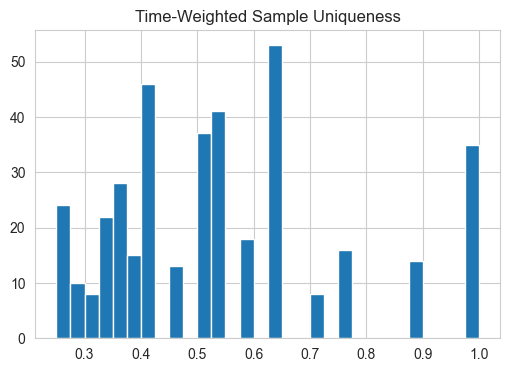

In [6]:
ax = out['tw'].hist(bins=30, figsize=(6, 4))
ax.set_title('Time-Weighted Sample Uniqueness')


In [10]:
def getIndicatorMatrix(events, close):
    """
    Create an indicator matrix (bool DataFrame) where:
    - Rows: event start time (t0)
    - Columns: close index (timestamps)
    - True: if event covers that timestamp
    """
    indM = pd.DataFrame(0, index=events.index, columns=close.index)
    for t0, t1 in events['t1'].items():
        indM.loc[t0, t0:t1] = 1
    return indM

def getAvgUniqueness(indM):
    c = indM.sum(axis = 1) # concurrency
    u = indM.div(c, axis = 0) # uniqness
    avgU = u[u > 0].mean()
    return avgU

def seqBootstrap(indM, sample_size=None):
    if sample_size is None:
        sample_size = indM.shape[1]
    phi = []
    while len(phi) < sample_size:
        avgU = pd.Series()
        for i in indM:
            indM_ = indM[phi + [i]] #reduce indM
            avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]
        prob = avgU / avgU.sum()
        phi += [np.random.choice(indM.columns, p = prob)]
    return phi

In [8]:

print("indM index:", indM.index[:5])
print("events index:", events.index[:5])


NameError: name 'indM' is not defined